# IMPORTS E LOADS

In [17]:
import pandas as pd
from pathlib import Path
import re
from unidecode import unidecode

try:
    # Tenta pegar o caminho do arquivo (funciona em scripts .py)
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # Se falhar (Jupyter), pega o diretório atual de trabalho
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent.parent 
DATA_DIR = PROJECT_ROOT / "2. Dados Recebidos" / "Base Campinas" / "Base K-Means"

path_origem = DATA_DIR #/ 'dados_recebidos'
path_destino = DATA_DIR #/ 'dados_processados'

base_vendas_caminho = path_origem / 'base_kmeans_comolatti2025_filtrada.parquet'
base_vendas = pd.read_parquet(base_vendas_caminho)

def ajusta_nome_colunas (coluna):
        """
        Função para ajustar nomes de colunas, removendo caracteres especiais, espaços e acentuação.
        
        Parâmetros:
        coluna (str): Nome da coluna a ser ajustado.
        """

        coluna = coluna.lower().strip()
        dAjuste = {"%":"pct",
                " ":"_"}
        
        for de, para in dAjuste.items():
            coluna = coluna.replace(de, para)
            coluna=re.sub(r'[^\w ]',"",coluna)
            coluna = unidecode(coluna)
        return coluna

In [18]:
base_vendas.columns = [ajusta_nome_colunas(x) for x in base_vendas.columns]
base_vendas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395002 entries, 0 to 395001
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   data_movto         395002 non-null  object 
 1   anomes             395002 non-null  object 
 2   id_empresa         395002 non-null  int64  
 3   id_filial          395002 non-null  int64  
 4   id_filial_fat      395002 non-null  int64  
 5   id_logo            395002 non-null  int64  
 6   nota_fiscal        395002 non-null  int64  
 7   seq_nf             395002 non-null  int64  
 8   documento_cliente  395002 non-null  object 
 9   nome_cliente       395002 non-null  object 
 10  uf_cliente         395002 non-null  object 
 11  segmento           395002 non-null  object 
 12  canal_origem       395002 non-null  object 
 13  id_funcionario     395002 non-null  int64  
 14  cod_produto        395002 non-null  int64  
 15  descricao          394996 non-null  object 
 16  co

# LIFT

In [19]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import os
# import funcoes as fc
pd.set_option('display.max_columns',None)

In [20]:
print('Produtos únicos: ', len(base_vendas.cod_produto.unique()))
print('Logomarcas únicas: ', len(base_vendas.marca.unique()))
print('Categorias únicas: ', len(base_vendas.cod_grupo.unique()))
print('Clientes únicos: ', len(base_vendas.nome_cliente.unique()))

Produtos únicos:  30961
Logomarcas únicas:  133
Categorias únicas:  723
Clientes únicos:  2057


In [32]:
coluna_cliente = 'nome_cliente'
coluna_item = 'cod_grupo'  # 'cod_produto' ou 'marca' ou 'cod_grupo'
coluna_categoria = 'cod_grupo'
coluna_peso = 'vlr_liquido'

In [33]:
df = base_vendas.copy()
#df.dropna(subset=[coluna_item], inplace=True)
lista_clientes = df[[coluna_cliente]].drop_duplicates()[coluna_cliente].values
print(f'Número de clientes únicos: {len(lista_clientes)}')
produtos = df.groupby(coluna_item)[[coluna_peso]].sum().sort_values(by=coluna_peso, ascending=False)
produtos['peso_cum'] = produtos[coluna_peso].cumsum()
total_revenue = produtos[coluna_peso].sum()
produtos['peso_cum'] = (produtos['peso_cum'] / total_revenue) * 100
produtos = list(produtos[produtos['peso_cum'] <= 95].index.values)
print(f'Número de produtos que representam 95% do faturamento: {len(produtos)}')

Número de clientes únicos: 2057
Número de produtos que representam 95% do faturamento: 204


In [35]:
df2 = df.copy()
df2['pedido'] = df2['nf_completa']
pedidos = list(df2['pedido'].drop_duplicates().values)
df2 = df2[df2.pedido.isin(pedidos)].copy()
df3 = pd.crosstab(df2['pedido'], df2[coluna_item])
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

compras_cliente = df3.map(encode_units).astype(bool)

In [36]:
compras_cliente

cod_grupo,0001A,0001B,0001BL,0001C,0001D,0001E,0001F,0001H,0001I,0001J,0001K,0001L,0001M,0001N,0001O,0001P,0001Q,0001R,0001S,0001T,0001U,0001V,0001W,0001X,0001Z,0001ZZ,0002V,0005B,0005C,0005E,0005F,0005H,0005L,0005M,0005P,0005V,0005X,0005Z,0007F,0007G,0007L,0007M,0007P,0007S,0008B,0008D,0008E,0008F,0008G,0008H,0008M,0008R,0008S,0008T,0008V,0008W,0008X,0009C,0009D,0009E,0009F,0009S,0009T,0009V,0011,0011A,0011B,0011C,0011F,0011H,0011L,0011M,0011P,0011Q,0011S,0011W,0012C,0012E,0012G,0012I,0012K,0012M,0012V,0012W,0012X,0013B,0013C,0013H,0013I,0013M,0013O,0013S,0014A,0014B,0014C,0014D,0014E,0014F,0014G,0014H,0014I,0014J,0014K,0014L,0014M,0014N,0014O,0014P,0014Q,0014R,0014S,0014T,0014U,0014V,0014W,0014X,0015A,0015B,0015C,0015K,0015L,0015M,0015O,0015P,0015R,0016B,0016C,0016D,0016F,0016H,0016L,0016P,0016T,0016Z,0017A,0017B,0017E,0017F,0017M,0017Q,0017V,0018B,0018C,0018D,0018F,0018H,0018I,0018J,0018L,0018R,0018S,0018V,0019A,0019M,0019P,0020B,0020C,0020E,0020G,0020K,0020O,0020P,0020Q,0022B,0022D,0022G,0022L,0022N,0022O,0022P,0022R,0022S,0022T,0022W,0023,0023A,0023E,0023G,0024A,0024B,0024C,0024D,0024E,0024F,0024K,0024L,0024R,0024S,0024X,0029B,0029C,0029D,0029E,0029K,0029L,0029P,0029T,0029V,0030A,0030B,0030C,0030D,0030E,0030L,0030P,0040B,0040C,0040D,0040E,0040J,0040K,0040M,0040N,0040O,0040P,0040Q,0040R,0040S,0040U,0040V,0040X,0040Y,0040Z,0042,0042A,0042B,0042J,0042L,0042P,0042R,0043A,0043B,0043C,0046,0047A,0047C,0047D,0047E,0047I,0047P,0047T,0050A,0053A,0053B,0053C,0053F,0053H,0053I,0053J,0053L,0053O,0053P,0053R,0053T,0056F,0060,0060B,0061A,0061B,0061C,0061F,0061P,0063,0064,0064C,0064D,0068,0068A,0068C,0068E,0068K,0068L,0068P,0068T,0068U,0069,0069A,0070D,0070G,0070I,0070L,0070M,0070O,0070P,0070R,0070S,0070T,0070X,0077D,0079,0079D,0079L,0079M,0079P,0079T,0080B,0080F,0081,0081A,0083P,0083V,0091A,0091H,0091I,0091J,0091M,0091P,0093,0093M,0099C,0099D,0099E,0099F,0099T,0102L,0102P,0104A,0104C,0104D,0104E,0104K,0104M,0104P,0104S,0107A,0107B,0107C,0107D,0107E,0114,0117,0117A,0117D,0117F,0117L,0117P,0117R,0117S,0117X,0118,0118E,0118K,0118P,0118S,0118V,0118Z,0131,0132,0138,0138A,0138H,0138I,0138M,0142A,0142C,0142S,0146,0146T,0149B,0149C,0149E,0149L,0149M,0149N,0149O,0149P,0149R,0149S,0149V,0153G,0153L,0153M,0153O,0153P,0153R,0153S,0153T,0153X,0168A,0168K,0168P,0168T,0170,0170C,0193A,0193D,0193G,0193P,0193S,0193T,0194,0200C,0200D,0200E,0200G,0200S,0200T,0200V,0209,0209A,0209B,0209C,0209D,0209E,0209F,0209G,0209H,0209I,0211A,0211P,0211R,0243A,0243B,0243C,0277C,0291,0292T,0293,0293A,0293B,0293C,0293E,0293M,0293R,0293S,0320,0320C,0322,0400,0404A,0404C,0417A,0417M,0417T,0418,0418A,0418B,0418C,0418F,0418H,0418K,0418L,0418O,0421A,0421B,0427A,0427B,0427C,0427D,0427E,0427F,0485,0500,0507E,0514B,0514K,0514O,0515R,0518B,0518D,0518L,0523,0523A,0523E,0524C,0524S,0530C,0530E,0530G,0530H,0530I,0535,0547P,0548R,0553P,0570T,0605H,0611A,0611B,0630,0630A,0630B,0630C,0630D,0630E,0630F,0630G,0630H,0630I,0630J,0640A,0640B,0640C,0640D,0640E,0640F,0640G,0640H,0640O,0640Z,0700G,0700I,0700K,0700N,0700W,0701E,0710,0716,0716P,0717,0718,0718A,0719,0720D,0720T,0721,0721A,0721B,0721C,0721F,0721G,0721H,0721I,0721J,0721K,0721L,0721M,0721N,0721O,0721P,0721Q,0721R,0721S,0721T,0721U,0721V,0721W,0721X,0721Y,0721Z,0722,0722A,0722E,0722F,0723,0723A,0723B,0723C,0723D,0723E,0723F,0723G,0723H,0723I,0723J,0723L,0723M,0723O,0723P,0724,0724A,0724B,0724C,0724D,0724E,0724F,0724G,0724H,0724I,0724J,0724M,0724N,0724O,0724P,0724Q,0724S,0725,0725A,0725E,0725F,0726,0726A,0726B,0728,0794,0803I,0803T,0803V,0804,0804A,0804B,0804C,0804D,0804F,0804G,0804H,0804I,0804L,0804M,0804N,0806,0807,0809,0809A,0809B,0809C,0809L,0809P,0810,0810A,0810B,0810C,0810D,0810E,0810F,0810J,0810K,0811,0812,0812E,0812F,0812H,0812L,0813,0813A,0813B,0817T,0817Z,0826,0828A,0828B,0828C,0833,0833B,0835,0835A,0835B,0835C,0835D,0835E,0835H,0837,0837B,0837C,0837D,0837F,0837G,0845A,0845B,0845C,0845E,0845F,0845G,0845I,0845K,0845L,0845M,0845N,0845Q,0845R,0845S,0845T,0845U,0845V,0845W,0846,0846A,0847A,0847D,0847E,0847F,0847H,0847T,0848R,085

In [37]:
frequent_itemsets = apriori(compras_cliente, min_support=0.01, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by=['support'],ascending=False)

rules = association_rules(frequent_itemsets, metric="lift")

# print("Regras para o cluster geradas")
rules.antecedents = rules.antecedents.apply(lambda x: list(x))
rules.consequents = rules.consequents.apply(lambda x: list(x))

rules['tam_consequents'] = rules.consequents.str.len()
rules['tam_antecedents'] = rules.antecedents.str.len()  

rules.to_parquet(path_destino / 'lift_categoria.parquet', index=False)
rules.to_excel(path_destino / 'lift_categoria.xlsx', index=False)
# print("Arquivo salvo em ", caminho_resultado)

In [38]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,tam_consequents,tam_antecedents
0,[0001N],[0001I],0.031140,0.047752,0.012807,0.411260,8.612336,1.0,0.011320,1.617433,0.912296,0.193788,0.381736,0.339724,1,1
1,[0001I],[0001N],0.047752,0.031140,0.012807,0.268189,8.612336,1.0,0.011320,1.323921,0.928212,0.193788,0.244668,0.339724,1,1
2,[0611B],[0040K],0.045059,0.115805,0.012710,0.282088,2.435881,1.0,0.007492,1.231620,0.617285,0.085793,0.188061,0.195923,1,1
3,[0040K],[0611B],0.115805,0.045059,0.012710,0.109757,2.435881,1.0,0.007492,1.072675,0.666675,0.085793,0.067751,0.195923,1,1
4,[0001F],[0014L],0.051612,0.071089,0.011823,0.229080,3.222455,1.0,0.008154,1.204939,0.727210,0.106633,0.170083,0.197698,1,1
5,[0014L],[0001F],0.071089,0.051612,0.011823,0.166316,3.222455,1.0,0.008154,1.137587,0.742458,0.106633,0.120946,0.197698,1,1
6,[0091A],[0014L],0.067582,0.071089,0.011021,0.163081,2.294051,1.0,0.006217,1.109918,0.604976,0.086341,0.099033,0.159059,1,1
7,[0014L],[0091A],0.071089,0.067582,0.011021,0.155038,2.294051,1.0,0.006217,1.103502,0.607259,0.086341,0.093794,0.159059,1,1
8,[0611A],[0611B],0.067689,0.045059,0.010765,0.159033,3.529487,1.0,0.007715,1.135529,0.768706,0.105556,0.119353,0.198971,1,1
9,[0611B],[0611A],0.045059,0.067689,0.010765,0.238909,3.529487,1.0,0.007715,1.224966,0.750489,0.105556,0.183650,0.198971,1,1


In [27]:
# verificar quantos itens únicos existem em cada categoria
for categoria in df[coluna_categoria].unique():
    print(f"{categoria}: {len(df[df[coluna_categoria] == categoria][coluna_item].unique())}")
    df_cat = df[df[coluna_categoria] == categoria].copy()
    df_cat = df_cat[df_cat[coluna_item].notna()]

    

PECAS GERAL: 1401
TAMPAS, PORTAS, SUPORTES E TELAS: 134
FILTROS HIDRAULICOS DE SUCCAO: 21
FILTROS OLEO MOTOR: 43
SENSORES: 176
MANGUEIRAS: 374
SISTEMAS FILTRO DE RESPIRO: 13
FILTROS HIDRAULICOS: 46
PECAS REPARO: 1112
AR CONDICIONADO: 58
RODA MOTRIZ: 20
PECAS CONSUMIVEIS: 391
FILTROS: 44
PECAS INTERNAS REPARO BOMBAS, MOTORES TRACAO, GIRO, VALVULAS: 84
FILTROS COMBUSTIVEL MOTOR: 68
FILTROS AR CONDICIONADO: 27
GERAL VALVULAS: 148
PECAS INTERNAS MITSUBISHI: 148
PECAS INTERNAS EIXOS: 902
SISTEMAS ELETRICOS: 288
SISTEMAS HIDRAULICOS: 144
KIT VEDACAO: 293
PECAS INTERNAS CUMMINS: 254
PECAS INTERNAS BOMBAS, MOT. TRACAO, GIRO, VALVULAS E MOTORES: 946
PECAS DO MOTOR: 248
PECAS INTERNAS KUBOTA: 51
SISTEMAS FILTRO DE AR: 60
PARAFUSOS, PORCAS, ARRUELAS E BRACADEIRAS: 1035
FPS: 108
BUCHAS, PINOS E COLARES: 594
PECAS CARRINHO: 117
RESFRIAMENTO: 56
GERAL BOMBA: 43
BOMBAS HIDRAULICAS: 42
ESTEIRAS: 12
MANCAL: 226
RADIADORES E RADIADORES DE OLEO: 51
PECAS ESPECIAIS: 234
OUTRAS PECAS: 307
PECAS INTERNAS H.

# SNA

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network
import os
# import funcoes as fc
pd.set_option('display.max_columns',None)

def analise_sna(df,coluna_cliente,coluna_item,coluna_peso,caminho_resultado):

    G = nx.Graph()
    G.clear()
    # # Substitua o loop for por isto:
    # G = nx.from_pandas_edgelist(df,         
    #                             source=coluna_cliente, 
    #                             target=coluna_item, 
    #                             edge_attr=coluna_peso)
    

    for index, row in df.iterrows():
        no_de = row[coluna_cliente]
        no_para = row[coluna_item]
        peso = row[coluna_peso]


        G.add_node(no_de)
        G.add_node(no_para)
        G.add_edge(no_de, no_para, weight=peso)
    
    nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    nt.from_nx(G)
    # nt.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09, overlap=0)
    # nt.toggle_physics(False)
    nt.show_buttons(filter_=['physics'])
    nome_arquivo_html = "rede_sna.html"
    # nt.show(nome_arquivo_html, notebook=True)
    # nt.save_graph(nome_arquivo_html)

    centr_grau = nx.degree_centrality(G) 
    centr_prox =  nx.closeness_centrality(G) 
    centr_betw = nx.betweenness_centrality(G)
    df_metricas = pd.DataFrame()
    for nome, centr in [['grau_centralidade',centr_grau],['proximidade', centr_prox],['intermediação',centr_betw]]:
        metricas = pd.DataFrame.from_dict(centr,orient='index',columns=[nome])
        metricas = metricas[metricas.index.isin(df[coluna_item].unique())].copy()
        metricas = pd.DataFrame(metricas.stack())
        df_metricas = pd.concat([df_metricas,metricas])

    df_metricas = df_metricas.unstack(level=1).droplevel(level=0,axis=1)
    
    # top_nos = df_metricas.sort_values(by='grau_centralidade', ascending=False).head(100).index.tolist()
    # G_sub = G.subgraph(top_nos)
    # nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    # nt.from_nx(G_sub)
    # nt.save_graph("rede_sna_top100.html")
    # nt.show("rede_sna_top100.html") 
    df_metricas.to_excel(caminho_resultado)
    # df_metricas.to_parquet(path_destino / f'sna_produto.parquet', index=False)

    return df_metricas, G

In [42]:
# df = pd.read_parquet('data/bronze/base.parquet')

# clusters = pd.read_excel(r"C:\Users\bruno\OneDrive\git-volix\volix-data-science\clusterizacao_clientes\vivix\data\gold\001\resultado.xlsx")

# df = df.merge(clusters[['cliente_grupo','cluster']],on='cliente_grupo',how='left').dropna(subset=['cluster'])


coluna_cliente = 'nome_cliente'
coluna_item = 'marca'  # 'cod_produto' ou 'marca' ou 'cod_grupo'
coluna_peso = 'vlr_liquido'
# cluster = 4
df_sna = df[[coluna_cliente,coluna_item,coluna_peso]].dropna().copy()
caminho_resultado =  path_destino / f'sna_{coluna_item}.xlsx'

df_metricas, G = analise_sna(df_sna,coluna_cliente,coluna_item,coluna_peso,caminho_resultado)

In [53]:
from pyvis.network import Network
from IPython.display import IFrame
import os

top_nos = df_metricas.sort_values(by='grau_centralidade', ascending=False).head(100).index.tolist()
G_sub = G.subgraph(top_nos)
nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
nt.from_nx(G_sub)
# 3. (Opcional) Desliga a física se for pesado
# nt.toggle_physics(False)

# 4. Salva o arquivo HTML temporário
nome_arquivo = "rede_sna_top100.html"
nt.save_graph(nome_arquivo)

# 5. Exibe usando IFrame
# Isso cria uma janela dentro da célula mostrando o HTML
# IFrame(src=nome_arquivo, width="100%", height="650px")

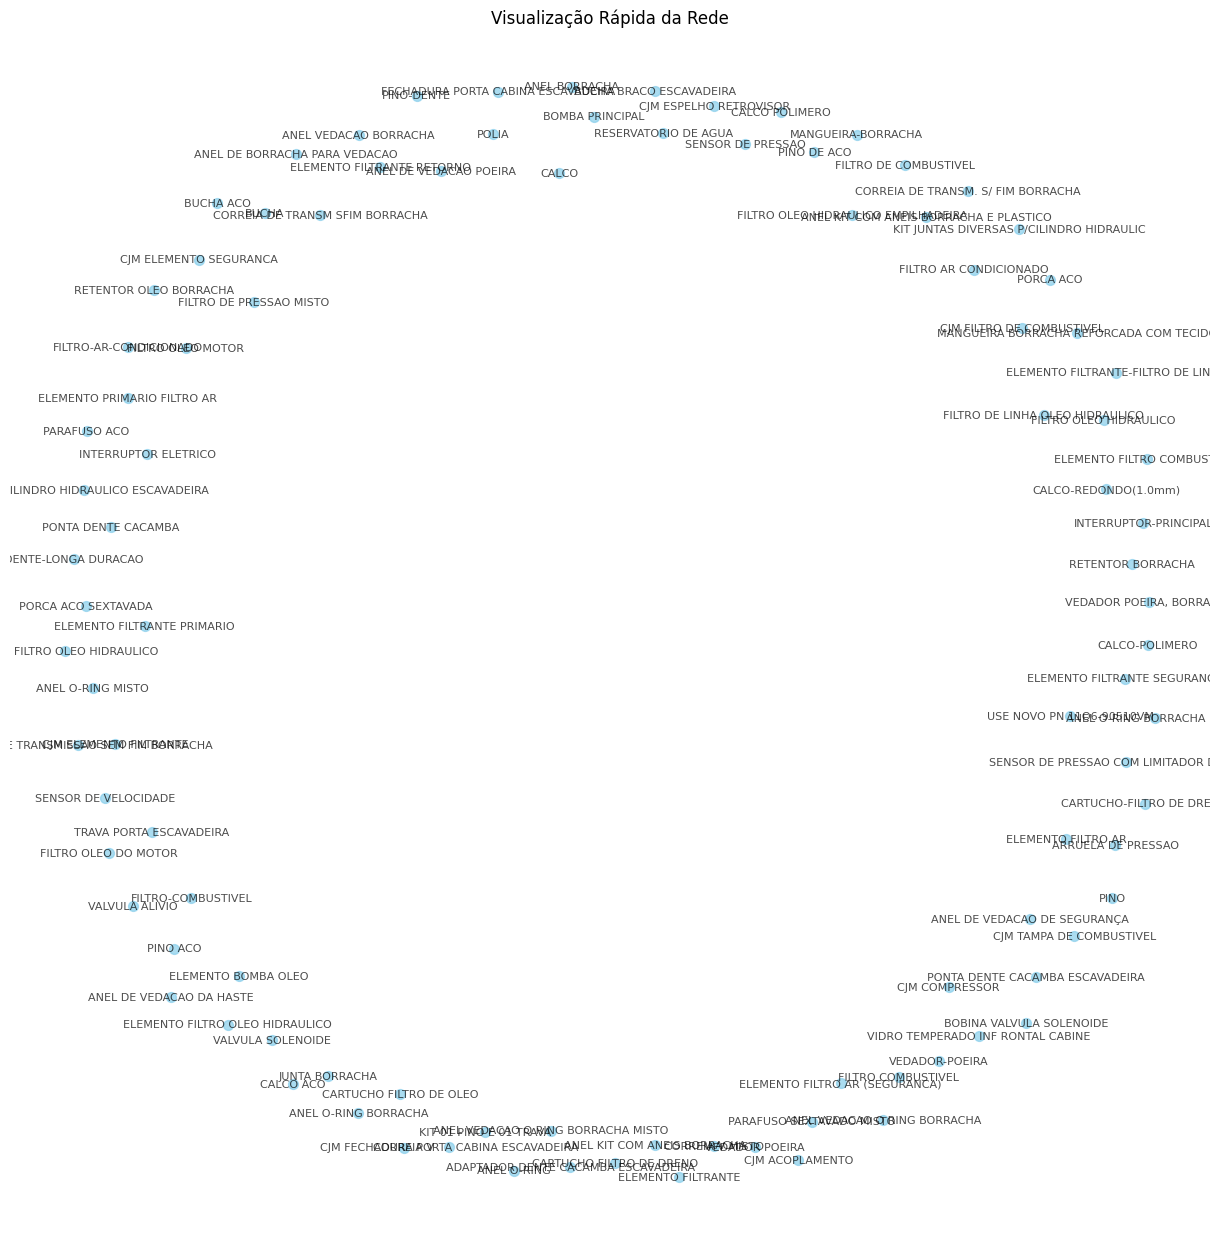

In [52]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 12))

# Define o layout (a "física" estática)
pos = nx.spring_layout(G_sub, seed=42, k=0.15) # k ajusta o espaçamento

# Desenha
nx.draw(
    G_sub, 
    pos,
    with_labels=True,     # Mostra nomes
    node_size=50,         # Tamanho da bolinha
    font_size=8,          # Tamanho da letra
    node_color="skyblue", 
    edge_color="gray", 
    alpha=0.7             # Transparência
)

plt.title("Visualização Rápida da Rede")
plt.show()

In [21]:

# coluna_cliente = 'nome_cliente'
# coluna_item = 'cod_produto'
# coluna_peso = 'faturamento_liquido'
# # cluster = 4
# df_sna = df[(df.grupo_3!='grupo_3')][[coluna_cliente,coluna_item,coluna_peso]].dropna().copy()
# caminho_resultado =  path_destino / f'analise_sna_produto.xlsx'

# analise_sna(df_sna,coluna_cliente,coluna_item,coluna_peso,caminho_resultado)